In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# Notebook params
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})

In [3]:
org_data = pd.read_csv('source/data.csv')

print('Dataset shape:',org_data.shape)
with pd.option_context('display.max_columns', None):
    display(org_data.head())

Dataset shape: (10000, 21)


,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,569520,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False,37.454012,1000.000000
1,750365,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True,95.071431,1333.333333
2,199901,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False,73.199394,916.666667
3,478866,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False,59.865848,916.666667
4,731664,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True,15.601864,1000.000000


#### Exploratory Data Analysis

In [19]:
org_data.describe()

,id,credit_score,postal_code,annual_mileage,speeding_violations,DUIs,past_accidents,telematic_score,monthly_mileage
count,10000.000000,9018.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000,9043.000000
mean,500521.906800,0.515813,19864.548400,11697.003207,1.482900,0.23920,1.056300,49.415956,974.750267
std,290030.768758,0.137688,18915.613855,2818.434528,2.241966,0.55499,1.652454,28.763013,234.869544
min,101.000000,0.053358,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.001163,166.666667
25%,249638.500000,0.417191,10238.000000,10000.000000,0.000000,0.00000,0.000000,24.632887,833.333333
50%,501777.000000,0.525033,10238.000000,12000.000000,0.000000,0.00000,0.000000,49.252862,1000.000000
75%,753974.500000,0.618312,32765.000000,14000.000000,2.000000,0.00000,2.000000,74.000635,1166.666667
max,999976.000000,0.960819,92101.000000,22000.000000,22.000000,6.00000,15.000000,99.971767,1833.333333


In [43]:
# 1. What proportion of customers with a credit score below 0.2 made a claim in the last year?
small_credit = org_data[org_data.credit_score<0.2]
small_credit_claim = small_credit['outcome'].value_counts(normalize=True).to_frame().T[True][0]
print('{} percent of customers with a credit score below 0.2 made a claim last year'.format(round(small_credit_claim*100)))

60 percent of customers with a credit score below 0.2 made a claim last year


Text(0, 0.5, 'Number of cases')

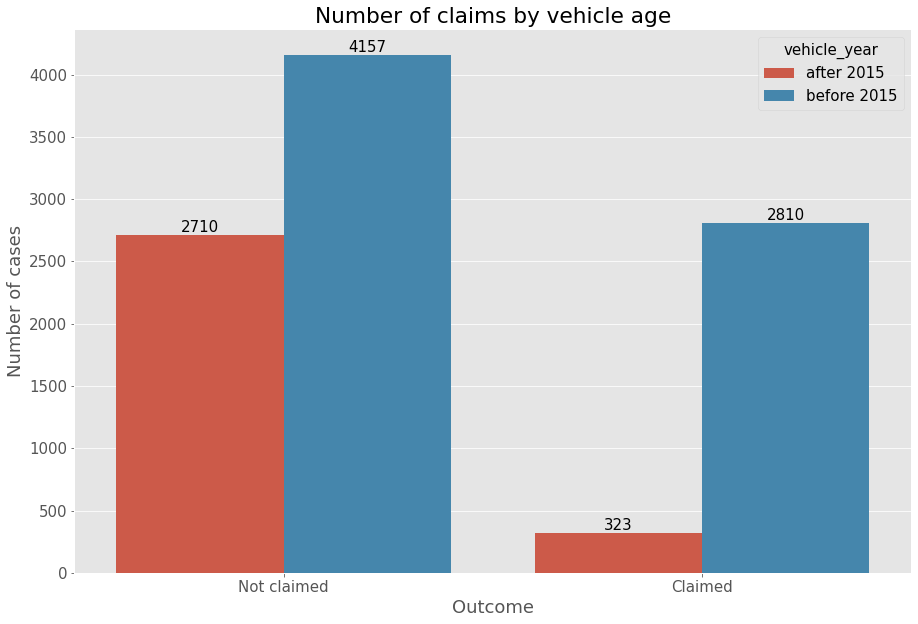

In [59]:
# Main points visualization
plt.rcParams["figure.figsize"] = (15,10)

org_data['Outcome'] = np.where(org_data['outcome'], 'Claimed', 'Not claimed')
ax = sns.countplot(data=org_data, x='Outcome', hue='vehicle_year')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by vehicle age')
plt.xlabel('Outcome')
plt.ylabel('Number of cases')

The plot presents number of claims made and not by available vehicle age.

For over 40% of vehicles older than 2015 a claim has been made. In the case of younger vehicles this is just ~10%. This could be due to various reasons, like worse equipment on the older cars. Younger vehicles have overall better systems, like traction control or special sensors for keeping a car in line. As the risk of making a claim is significantly higher for the older vehicles, their premiums should be higher as well.

Text(0, 0.5, 'Number of cases')

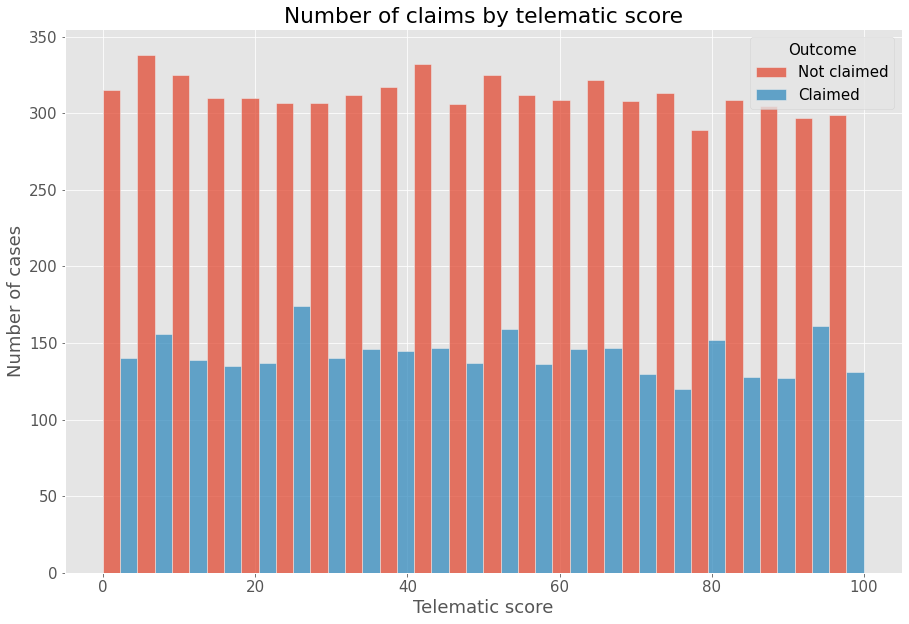

In [65]:
ax = sns.histplot(data=org_data, x='telematic_score', hue='Outcome',multiple='dodge')

plt.title('Number of claims by telematic score')
plt.xlabel('Telematic score')
plt.ylabel('Number of cases')

Interestingly, the telematic score does not seem to have any effect on the claims. For vast majority of scores the claims oscillate around 30% of all cases. That would suggest, that the driving style does not impact the accidents. This seems counter-intuitive, but it can be explained. One possibility would be malfunctioning or bad telematics devices. If that is the case, the algorithm in these devices should be adjusted or replaced. Second possibility is the randomization of provided data, in which case it is not possible to say more until more records are provided.  

Text(0, 0.5, 'Number of cases')

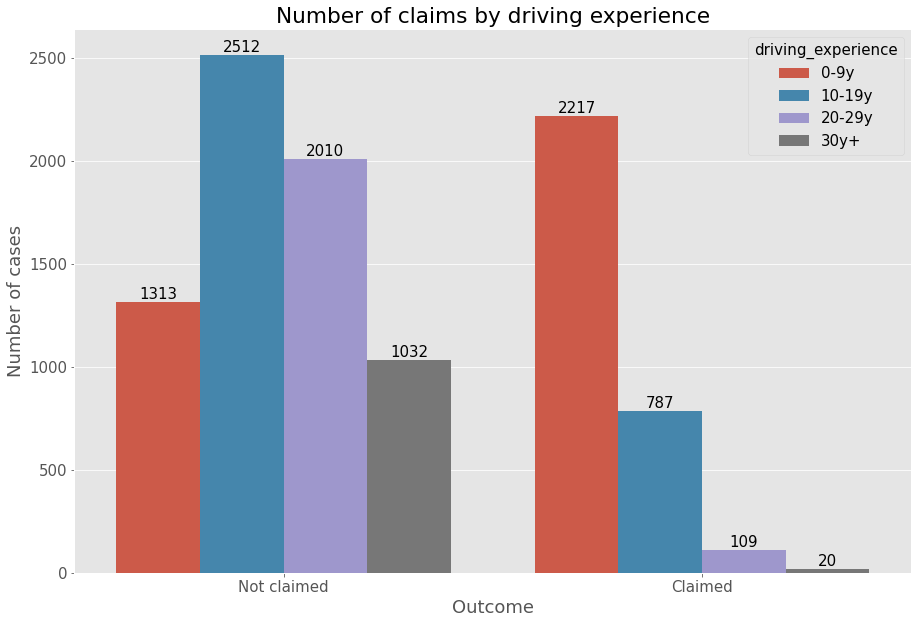

In [67]:
ax = sns.countplot(data=org_data, x='Outcome', hue='driving_experience')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by driving experience')
plt.xlabel('Outcome')
plt.ylabel('Number of cases')

Not only a clear majority of claims (70%) is done by drivers with short experience (<9 years), but also over 60% of all of these drivers made a claim in the last year. This shows, that young drivers (in terms of experience, not age) are more risky for a company and their premium should be higher.

#### Modelling